<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 2: Sem2 AY 23/24 - DQN Classic Control

Module Leader: J.J. Collins

Students:  
- Pratik Verma - 23007575
- Siddharth Prince - 23052058

---
## Code checks
| Sl. No. | Test case                             | Status |
|---------|---------------------------------------|--------|
| 1.      | [Imports and setup](#Imports-and-setup)  | <span style='color: orange'>In progress</span> |
| 2.      | [Capture and sampling of the data](#Capture-and-sampling-of-data) | <span style='color: #3af'>Awaiting</span> |
| 3.      | [Network structure and hyperparameters](#Network-structure-and-hyperparameters) | <span style='color: #3af'>Awaiting</span> |
| 4.      | [Q-learning updates](#Q-learning-updates) | <span style='color: #3af'>Awaiting</span> |
| 5.      | [Metrics and evalutation](#Metrics-and-evalutation) | <span style='color: #3af'>Awaiting</span> |
| 6.      | [Finetuning](#Finetuning) | <span style='color: #3af'>Awaiting</span> |
|   6.1      | [Experimenting with Double DQN](#Experimenting-with-Double-DQN) | <span style='color: #3af'>Awaiting</span> |
|   6.2      | [Experimenting with Dueling DQN](#Experimenting-with-Dueling-DQN) | <span style='color: #3af'>Awaiting</span> |

## References
- [DQN Tutorial | Pytorch.org](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [A Geron's Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow - Chapter 18 Reinforcement Learning sample notebook](https://github.com/ageron/handson-ml2/blob/8958d538bdcdf29d329d9950bfc79034c29db724/18_reinforcement_learning.ipynb)

CS6482 Deep Reinforcement Learning
Template for Assignment 2 DQN CartPole Classic Control

This sample code is based on one of the recommended texts. A small number of errors were deliberately injected into the code.

If using this code as a basis for Option 1:
•	Correct the bugs.
•	Comment the code extensively.
•	Replace CartPole with a different Classic Control problem form gym.
•	Generate more informative plots i.e. plot running average.
•	Consider generating an animation.
•	Play around with hyperparameters and parameters to achieve ‘satisfactory’ performance.

A template will NOT be provided for Assignment 3. Use this template and modify the following (1) shape of obs and actions (2) network structure, (3) storing and processing of experience, etc.

## Imports and setup

In [150]:
# Common imports
import sys
import numpy as np
import os
from collections import namedtuple, deque

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ML lib imports
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# OpenAI Gym import
import gym

import warnings 
warnings.filterwarnings('ignore') # To ignore the big red future warnings (for now and convenience)

In [5]:
# Version checks
assert sys.version_info >= (3,10)
assert sklearn.__version__ >= "0.20" # Scikit-Learn ≥0.20 is required

# to make this notebook's output stable across runs
SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Get available device for training
device = ( "cuda"     # CUDA for GPU compute
           if torch.cuda.is_available()
           else "cpu (not dice)" )   # CPU won't cut it. :P

print(f"{device} device available")

cuda device available


### Utility methods

In [143]:
# Utility methods

# Method that plots the current state of the environment as an image
# Taken from Geron's ml2 RL example notebook
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    # returns an image of the environment as a Numpy array. 
    # 'rgb-array' mode does this instead of opening a separate window that renders the image.
    img = env.render(mode="rgb_array")
    plt.imshow(img) # shows the image as a plot via Matplotlib's pyplot module in the cell output
    plt.axis("off") # does not display the plot axes and just the image.
    return img

# Method sets the current frame to be plotted for the corresponding frame in the animation
# Taken from Geron's ml2 RL example notebook
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Method that plots an animation of the environment that cycles through each frame that corresponds to each step taken
# Taken from Geron's ml2 RL example notebook
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # uses matplotlib's animation module. The FuncAnimation method repeatedly calls a specified method for the number of 
    # provided frames. The specified function that is called, 'update_scene' is defined above.
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

### Gym environment setup
Listing all the available OpenAI Gym environments to explore

In [4]:
allEnvs = gym.envs.registry.all() # Getting a list of all available gym environments and their specifications
envIds = [envSpec.id for envSpec in allEnvs] # Getting the id names for each environment's specification
print(sorted(envIds))

['ALE/Adventure-ram-v5', 'ALE/Adventure-v5', 'ALE/AirRaid-ram-v5', 'ALE/AirRaid-v5', 'ALE/Alien-ram-v5', 'ALE/Alien-v5', 'ALE/Amidar-ram-v5', 'ALE/Amidar-v5', 'ALE/Assault-ram-v5', 'ALE/Assault-v5', 'ALE/Asterix-ram-v5', 'ALE/Asterix-v5', 'ALE/Asteroids-ram-v5', 'ALE/Asteroids-v5', 'ALE/Atlantis-ram-v5', 'ALE/Atlantis-v5', 'ALE/Atlantis2-ram-v5', 'ALE/Atlantis2-v5', 'ALE/Backgammon-ram-v5', 'ALE/Backgammon-v5', 'ALE/BankHeist-ram-v5', 'ALE/BankHeist-v5', 'ALE/BasicMath-ram-v5', 'ALE/BasicMath-v5', 'ALE/BattleZone-ram-v5', 'ALE/BattleZone-v5', 'ALE/BeamRider-ram-v5', 'ALE/BeamRider-v5', 'ALE/Berzerk-ram-v5', 'ALE/Berzerk-v5', 'ALE/Blackjack-ram-v5', 'ALE/Blackjack-v5', 'ALE/Bowling-ram-v5', 'ALE/Bowling-v5', 'ALE/Boxing-ram-v5', 'ALE/Boxing-v5', 'ALE/Breakout-ram-v5', 'ALE/Breakout-v5', 'ALE/Carnival-ram-v5', 'ALE/Carnival-v5', 'ALE/Casino-ram-v5', 'ALE/Casino-v5', 'ALE/Centipede-ram-v5', 'ALE/Centipede-v5', 'ALE/ChopperCommand-ram-v5', 'ALE/ChopperCommand-v5', 'ALE/CrazyClimber-ram-v5'

/home/sprince0031/.local/lib/python3.10/site-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


We are choosing the _**'LunarLander-v2'**_ gym environment because (it sounds cool) it is a step up from the relatively simplistic cartpole problem while also not requiring us to deal with too many action and observation space variables. However, this environment's reward mechanism is fairly more nuanced. The full environment specification description is as follows:  
### LunarLander-v2 Specification:
#### Description:
- LunarLander is a classic rocket trajectory optimization problem.
- The goal is to land a lunar lander safely on the moon’s surface.
- The landing pad is always at coordinates (0,0).
- Fuel is infinite, allowing the agent to learn to fly and land successfully.
#### Action Space:
There are four discrete actions available:
- Do nothing
- Fire left orientation engine
- Fire main engine
- Fire right orientation engine
#### Observation Space:
The state is an 8-dimensional vector:
- Coordinates of the lander in x & y
- Linear velocities in x & y
- Angle of the lander
- Angular velocity
- Two booleans representing whether each leg is in contact with the ground or not.
#### Rewards:
- Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points.
- Moving away from the landing pad results in a loss of reward.
- Crashing incurs an additional -100 points.
- Successfully coming to rest earns an additional +100 points.
- Each leg with ground contact is +10 points.
- Firing the main engine costs -0.3 points per frame.
- Firing the side engine costs -0.03 points per frame.
- The environment is considered solved when the total reward reaches 200 points.
#### Starting State:
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.
#### Episode Termination:
The episode finishes if:
- The lander crashes (the lander body contacts the moon).
- The lander gets outside of the viewport (x coordinate greater than 1).
- The lander is not awake (a body that doesn’t move or collide with any other body).

In [138]:
# Setting the gym environment
env = gym.make('LunarLander-v2') # setting to the LunarLander environment
obs = env.reset(seed=SEED) # initialising the environment with the reset() method 

In [99]:
obs # seeing what the observation numpy array looks like

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

The observation for this environment consists of 1D array with 8 float values. The array indices correspond to the following:
1. x coordinate of lander
2. y coordinate of lander
3. velocity of lander in x direction
4. velocity of lander in y direction
5. Angle or orientation of the lander
6. Angular velocity of the lander
7. 1/0 (boolean) value for the left leg contacting the lunar surface
8. 1/0 (boolean) value for the right leg contacting the lunar surface

We can see that for the starting state here, the lander already has a velocity in the positive x and y directions as well as angular velocity. This makes sense because if it were just to spawn above the landing point with no inherited velacity, it would be a straightforward controlled drop down to the surface.

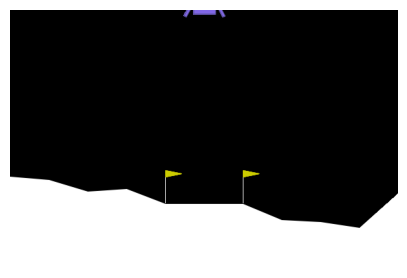

In [139]:
# Testing the rendering of LunarLander's environment
plot_environment(env)
plt.show()

## Capture and sampling of data

The action space consists of 4 actions:
- Do nothing (action index 0)
- Apply thrust using left orientation engine (action index 1)
- Apply thrust using main engine (action index 2)
- Apply thrust using right orientation engine (action index 3)

In [101]:
env.action_space

Discrete(4)

In [126]:
# Testing out an action step to get familiar with the values we're working with
action = 2  # Fire the main engine
obs, reward, done, info = env.step(action)
obs 

array([ 0.00443649,  1.4258697 ,  0.21735111,  0.34394354, -0.00602619,
       -0.06743145,  0.        ,  0.        ], dtype=float32)

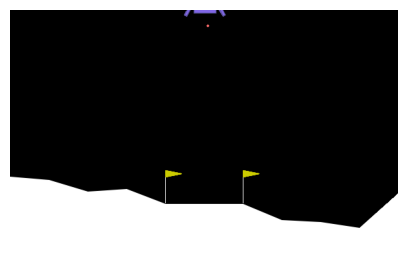

In [128]:
# Plotting the environment again to check the change in the observed state
plot_environment(env)
plt.show()

The main engine has fired from the above frame after the next step.

In [123]:
# Checking the reward obtained. This output was when I ran the first step with an action index value of 0 i.e, no action taken.
# So, the reward value starts at a non-zero positive value. I reset the env after and did this with an action index of 2 which
# is what is reflected above.
reward

1.1449803922348565

In [127]:
# Checking the reward obtained for the above step (firing the main engine for one frame)
reward

-2.497033478022092

Since firing the main engine incurs a -0.3 for a frame, we are already in the negative w.r.t to the reward value.

### Testing the env with a random policy
We just want to randomly sample an action step from the 4 available actions to see how it renders (and test if the animation works).

In [140]:
# Reset the environment to get the initial observation
obs = env.reset(seed=SEED)

frames = []
episodeReward = 0
for step in range(200): # running this for 200 frames
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)
    episodeReward += reward
    if done:
        break

In [141]:
# plot the animation from all the frames (steps) captured
plot_animation(frames)

In [142]:
len(frames)

98

The random policy crashed in 98 steps.

## Network structure and hyperparameters

In [229]:
env.action_space.n

4

In [157]:
n_observations = env.observation_space.shape[0]
n_outputs = env.action_space.n

# DQN model
class DQN(nn.Module):

    def __init__(self, n_observations, n_outputs):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

model = DQN(n_observations, n_outputs).to(device)

Defining the action policy function

In [208]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        state = torch.tensor(state, dtype=torch.float32, device=device)
        Q_values = model(state)
        Q_values = Q_values.detach().cpu().numpy()
        return np.argmax(Q_values[0])

Replay memory system

In [159]:
replay_memory = deque(maxlen=2000)

Function to sample experiences from replay memory

In [160]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [161]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Training function

In [223]:
batch_size = 32
discount_rate = 0.95
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # Compute Q-values for next states
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    next_Q_values = model(next_states)
    max_next_Q_values, _ = torch.max(next_Q_values, dim=1)

    # Compute target Q-values
    max_next_Q_values = max_next_Q_values.detach().cpu().numpy()
    target_Q_values = np.sum((rewards, (1 - dones) * discount_rate * max_next_Q_values))
    target_Q_values = torch.tensor(target_Q_values, dtype=torch.float32, device=device)
    target_Q_values = target_Q_values.view(-1, 1)

    # Create a one-hot mask for actions
    mask = torch.zeros(len(actions), n_outputs, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device)
    mask.scatter_(1, actions.view(-1, 1), 1)

    # Compute Q-values for current states
    states = torch.tensor(states, dtype=torch.float32, device=device)
    all_Q_values = model(states)
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdim=True)
    
    # Compute loss
    loss = torch.mean((target_Q_values - Q_values) ** 2)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

## Q-learning updates

In [224]:
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

rewards = [] 
best_score = 0

In [225]:
for episode in range(600):
    obs = env.reset(seed=SEED)    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.state_dict() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.load_state_dict(best_weights)

Episode: 599, Steps: 83, eps: 0.0104

<All keys matched successfully>

## Metrics and evalutation

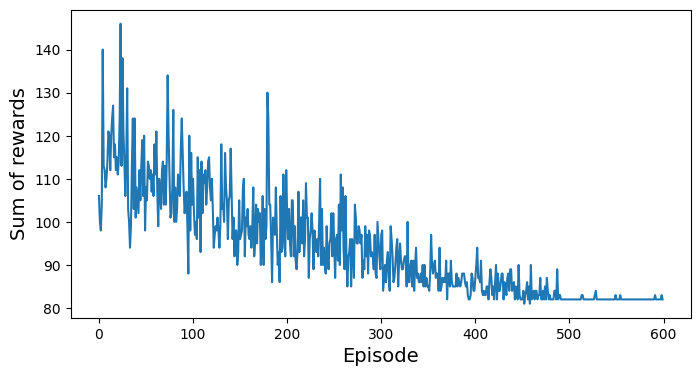

In [227]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
# save_fig("dqn_rewards_plot")
plt.show()

In [228]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

## Finetuning

### Experimenting with Double DQN

### Experimenting with Dueling DQN